In [3]:
!pip install scipy

     |████████████████████████████████| 33.2 MB 376 kB/s eta 0:00:01    |██▌                             | 2.5 MB 374 kB/s eta 0:01:22     |█████▋                          | 5.8 MB 371 kB/s eta 0:01:14     |██████████████████▋             | 19.3 MB 440 kB/s eta 0:00:32     |█████████████████████████████▋  | 30.7 MB 437 kB/s eta 0:00:06


In [14]:
import numpy as np
import pandas as pd
import itertools
from scipy import stats

In [126]:
class BasketOption:
    '''Functions for a European basket call option.'''
    
    def __init__(self, weights, prices, vol, corr, strike, time, rate):
        '''           
        Parameters
        ----------
        weights : ndarray
            Floats representing weights of the underlying assets in the basket. 
            Should sum to 1, be 1-D, and be of length equal to the length of prices.
        prices : ndarray
            Floats representing the asset prices at time zero. Should be 1-D, and same
            length as prices.
        vol : float
            The volatility of the assets. N.B. the Levy formula assumes homogeneous asset
            volatility.
        corr : ndarray
            Correlation matrix of the assets. Should be of shape (n,n), where n is the
            number of assets.
        strike : float
            Strike price.
        time : float
            Time to maturity.
        rate : float
            Riskless interest rate.
        '''
        self.weights = weights
        self.prices = prices
        self.vol = vol
        self.corr = corr
        self.strike = strike
        self.time = time
        self.rate = rate
    
        if not len(weights) == len(prices) == len(corr):
            raise ValueError('Number of weights, prices, corr rows should be equal')
            
        if abs(1-sum(weights))>0.01:
            raise ValueError('The weights must cumulatively sum to 1.0')
            
    def get_levy_price(self):
        """
        Use the Levy formula to approximate the price of a European basket call option.
        """
    
        discount = np.exp(-self.rate*self.time)
    
        # First moment of T-forward prices (also the basket T-forward price)
        m1 = np.sum(self.weights * self.prices * discount)

        # Second moment of T-forward prices
        w_ij, f_ij = [list(map(lambda x: np.product(x), list(itertools.product(q, q)))) 
                          for q in [self.weights, self.prices * discount]]
        m2 = np.sum(np.array(w_ij) * np.array(f_ij)
                    * np.exp(self.corr.flatten() * self.vol**2 * self.time))
    
        vol_basket = ( self.time**(-1) * np.log(m2 / m1**2) )**(0.5)
    
        # Parameters of the price formula
        d1 = np.log(m1 / self.strike)/(vol_basket * self.time**(0.5))\
                + (vol_basket * self.time**(0.5))/2
        d2 = d1 - vol_basket * self.time**(0.5)

        # Levy formula for basket call option price
        self.levy_price = discount * (m1 * stats.norm.cdf(d1) - strike * stats.norm.cdf(d2))

        return self.levy_price

In [127]:
basket_option = BasketOption(weights, prices, vol, corr, strike, time, rate)

In [128]:
basket_option.get_levy_price()

28.051966214249937

In [132]:
basket_option.prices

array([100., 100., 100., 100.])

In [100]:
weights = np.array([0.25,0.25,0.25,0.25])
prices = np.array([100.,100.,100.,100.])
vol = 0.4
corr = np.array([[1.,0.5,0.5,0.5],[0.5,1.,0.5,0.5],[0.5,0.5,1.,0.5],[0.5,0.5,0.5,1.]])
strike = 100.
time = 5
rate = 0.

levy_formula(weights, prices, vol, corr, strike, time, rate)

16752.537553540697


28.051966214249937

In [177]:
class SimulateBasketPrices:
    ''' 
    Simulate the prices of many European basket call options. This class
    assumes the underlying assets of each basket have the same initial price
    and the same weight in the basket. The model used to approximate the option
    price assumes equal volatility of the assets.
    '''
    
    def __init__(self, n_assets, n_prices=100):
        '''
        Parameters
        ----------
        n_assets : int
            Number of assets in the basket
        n_prices : int, optional
            Number of prices to simulate
        '''
        self.n_assets = n_assets
        self.n_prices = n_prices
        
    def simulate_prices(self, base_price, vol, corr, rate=0.):
        '''
        Parameters
        ----------
        base_price : float
            Average price of the simulated assets
        vol : float
            Average volatility of the simulated assets
        corr : ndarray
            Correlation matrix of the assets
        rate : float, optional
            Risk-free interest rate
        '''
        
        prices = np.random.randn(self.n_prices)*10 + base_price
        strikes = base_price * (0.5 + np.random.rand(self.n_prices))
        times = np.random.randint(0,15,self.n_prices)
        vols = np.abs((np.random.rand(self.n_prices)-0.5)*0.05 + vol)
        weights = np.array([1./self.n_assets,]*self.n_assets)
        print(weights)
        basket_prices = []
        for i in range(self.n_prices):
            basket = BasketOption(weights, np.ones(self.n_assets)*prices[i],
                                  vol, corr, strikes[i], 
                                  times[i].astype('float'), rate)
            basket_prices.append(basket.get_levy_price())
            
        self.simulated_baskets = pd.DataFrame({
                                    'Prices': prices,
                                    'Strike': strikes,
                                    'Maturity': times,
                                    'Volatility': vols,
                                    'Weighting': weights[0]*len(prices),
                                    'Rate': rate*len(prices),
                                    'Basket_Price': basket_prices})

In [178]:
simulator = SimulateBasketPrices(4)
simulator.simulate_prices(100, 0.4, corr)

[0.25 0.25 0.25 0.25]


/var/folders/wy/ybnn2vf96m38d53m5xdft1ch0000gn/T/ipykernel_89804/3440960751.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  vol_basket = ( self.time**(-1) * np.log(m2 / m1**2) )**(0.5)
/var/folders/wy/ybnn2vf96m38d53m5xdft1ch0000gn/T/ipykernel_89804/3440960751.py:57: RuntimeWarning: invalid value encountered in double_scalars
  vol_basket = ( self.time**(-1) * np.log(m2 / m1**2) )**(0.5)


In [183]:
df = simulator.simulated_baskets

In [186]:
import seaborn as sns

/opt/anaconda3/envs/multiverse/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Basket_Price'>

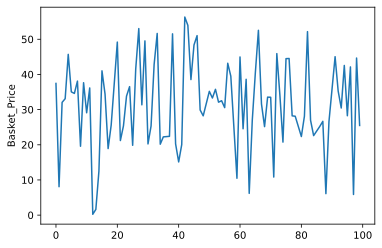

In [187]:
sns.lineplot(range(100), df.Basket_Price)

In [190]:
df[df.Basket_Price < 1]

,Prices,Strike,Maturity,Volatility,Weighting,Rate,Basket_Price
12,87.181231,57.040368,2,0.402706,25.0,0.0,0.236415
